C:\Users\sigme\AppData\Local\Temp\ipykernel_35616\1569605355.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ob_state = ob.groupby("locationabbr", as_index=False).apply(wavg)


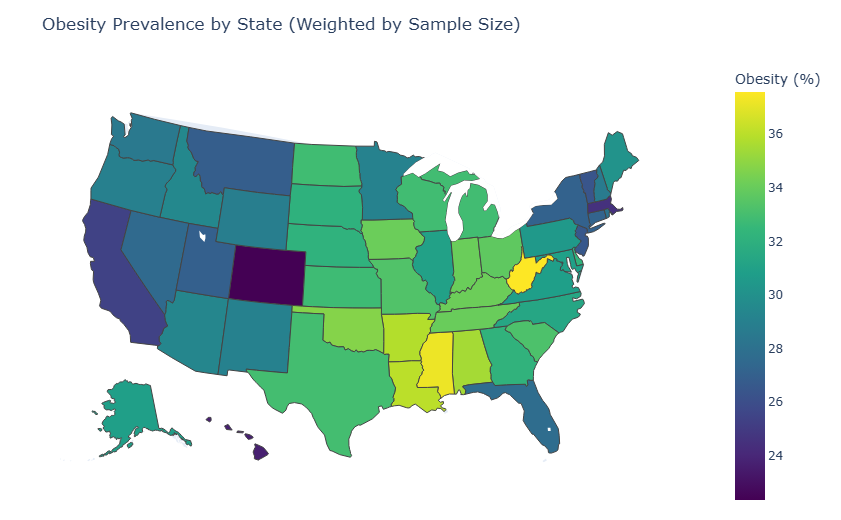

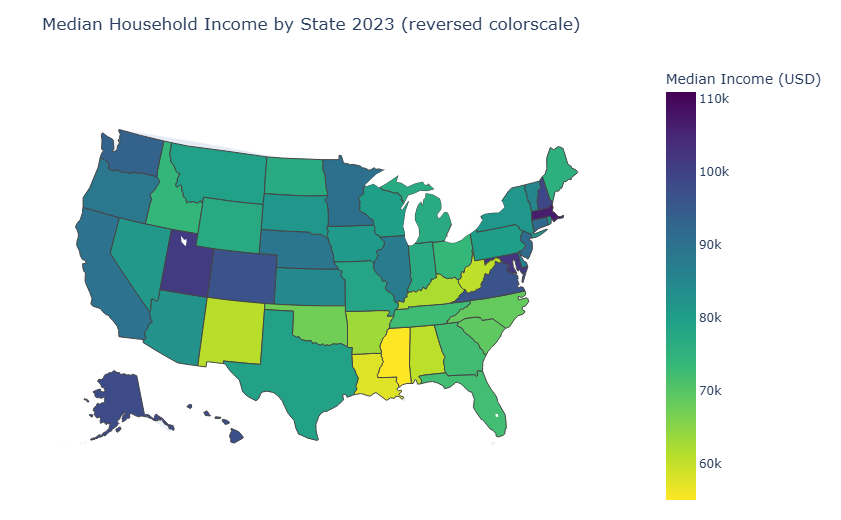

In [1]:
#creates 2 US map heatmaps, one for income one for obesity prev

#libraries
import numpy as np
import pandas as pd
import plotly.graph_objects as go

#imports
OBESITY_CSV = "data_clean/master_obesity_strata.csv"
INCOME_CSV  = "data_raw/state_median_income.csv"

#load
ob = pd.read_csv(OBESITY_CSV, dtype={"locationabbr":"string"})
inc = pd.read_csv(INCOME_CSV,  dtype={"locationabbr":"string"})

#verify
req_ob_cols  = {"locationabbr","obesity_pct","total_sample_size"}
req_inc_cols = {"locationabbr","state_median_income"}
missing_ob = req_ob_cols - set(ob.columns)
missing_inc = req_inc_cols - set(inc.columns)
if missing_ob:
    raise ValueError(f"Obesity CSV missing columns: {missing_ob}")
if missing_inc:
    raise ValueError(f"Income CSV missing columns: {missing_inc}")

#collapse obesity strata by state with sample size weights
def wavg(g):
    w = g["total_sample_size"].clip(lower=0)
    x = g["obesity_pct"]
    # if obesity_pct is mostly proportions, convert to %
    if x.dropna().le(1).mean() > 0.8:
        x = x * 100.0
    return pd.Series({
        "obesity_pct_w": np.average(x, weights=w) if w.sum() > 0 else x.mean(),
        "total_sample_size_sum": w.sum()
    })

ob_state = ob.groupby("locationabbr", as_index=False).apply(wavg)

#income
inc_state = inc.copy()

#obeisty weighted
fig_ob = go.Figure(go.Choropleth(
    locations=ob_state["locationabbr"],
    locationmode="USA-states",
    z=ob_state["obesity_pct_w"],
    colorscale="Viridis",
    colorbar_title="Obesity (%)",
    hovertemplate="<b>%{location}</b><br>" +
                  "Weighted obesity: %{z:.2f}%<br>" +
                  "Total sample: %{customdata:,}<extra></extra>",
    customdata=ob_state[["total_sample_size_sum"]]
))
fig_ob.update_layout(
    title="Obesity Prevalence by State (Weighted by Sample Size)",
    geo=dict(scope="usa", projection_type="albers usa", showlakes=True),
    margin=dict(l=10, r=10, t=60, b=10),
    height=520
)
fig_ob.show()

#median income reversed colorway
fig_inc = go.Figure(go.Choropleth(
    locations=inc_state["locationabbr"],
    locationmode="USA-states",
    z=inc_state["state_median_income"],
    colorscale="Viridis_r",
    colorbar_title="Median Income (USD)",
    hovertemplate="<b>%{location}</b><br>" +
                  "Median income: $%{z:,.0f}<extra></extra>"
))
fig_inc.update_layout(
    title="Median Household Income by State 2023 (reversed colorscale)",
    geo=dict(scope="usa", projection_type="albers usa", showlakes=True),
    margin=dict(l=10, r=10, t=60, b=10),
    height=520
)
fig_inc.show()
